In [ ]:
#| default_exp direct_optimization

In [ ]:
#| export
import jax
from inverse_design.brushes import notched_square_brush
from inverse_design.conditional_generator import (
    generate_feasible_design_mask,
    new_latent_design,
    transform,
)
from jax.example_libraries.optimizers import adam
from tqdm.notebook import trange

In [ ]:
#| include: false
import matplotlib.pyplot as plt

## Data

In [ ]:
shape = (M, N) = (30, 30)

### target
Let's - for now - just try to find a pre-defined design target (which we will construct with our generator)...

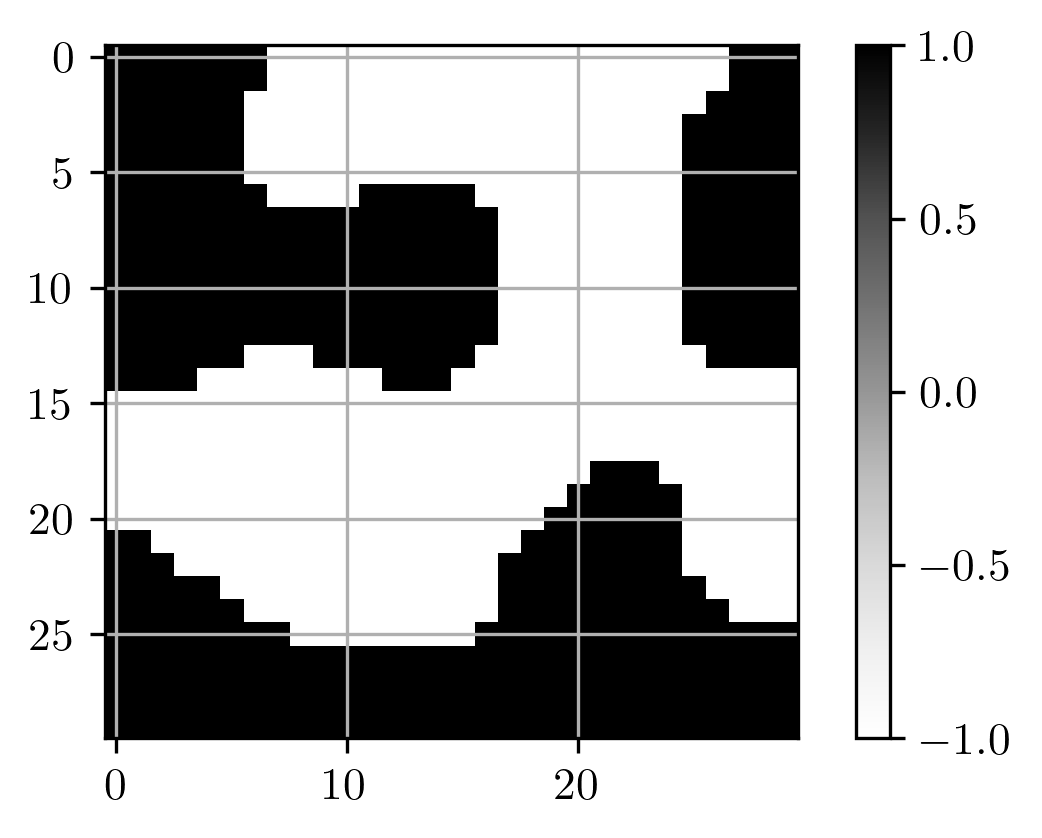

In [ ]:
brush_target = notched_square_brush(5, 1)
latent_target = new_latent_design(shape, r=42)
latent_target_t = transform(latent_target, brush_target)
mask_target = generate_feasible_design_mask(latent_target_t, brush_target)

plt.imshow(mask_target, cmap="Greys")
plt.colorbar()
plt.show()

### input

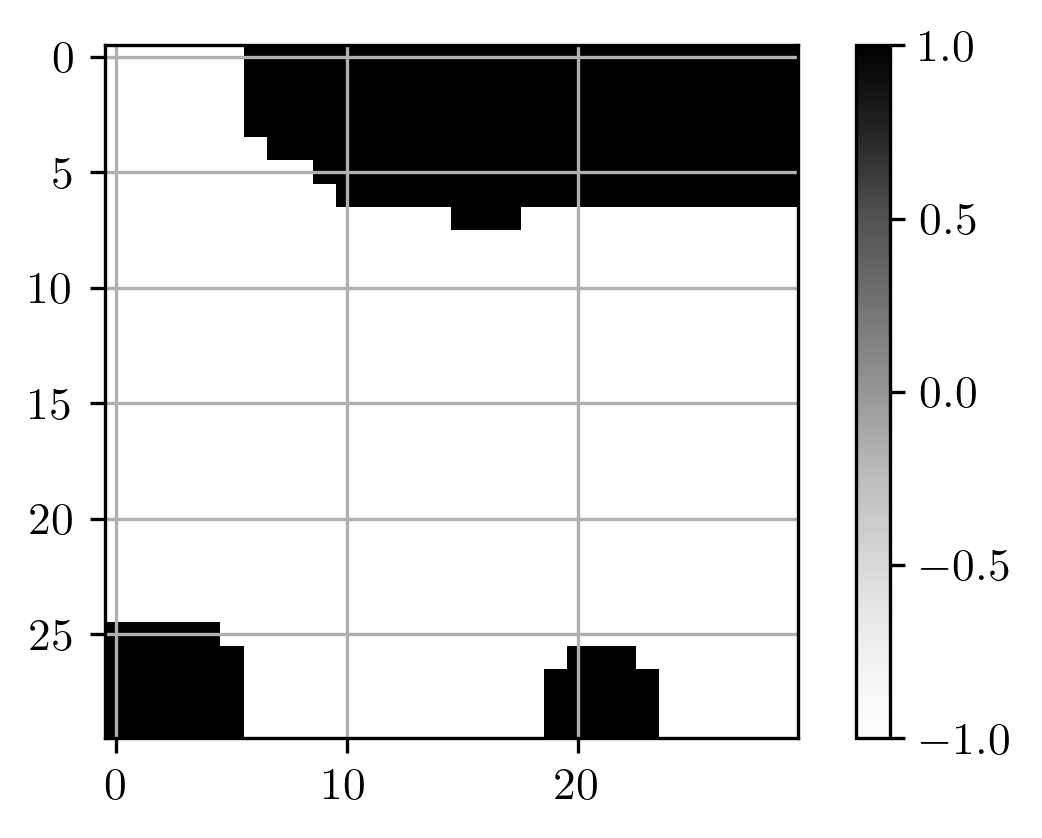

In [ ]:
brush_input = notched_square_brush(5, 1)
latent_input = new_latent_design(shape, r=0)
latent_input_t = transform(latent_input, brush_input)
mask_input = generate_feasible_design_mask(latent_input_t, brush_target)

plt.imshow(mask_input, cmap="Greys")
plt.colorbar()
plt.show()

## Loss Functions

In [ ]:
#| export
def mse(x, y) -> float:
    return ((x - y) ** 2).mean()

In [ ]:
#| export
def huber_loss(x, y, delta=0.5) -> float:
    return ((delta**2) * ((1.0 + ((x - y) / delta) ** 2) ** 0.5 - 1.0)).mean()

## Optimization

the loss function defines what we're optimizing.

In [ ]:
def forward(latent, brush):
    latent_t = transform(latent, brush)
    design_mask = generate_feasible_design_mask(latent_t, brush) # differentiable through STE
    return design_mask
    
def loss_fn(latent, brush, target_mask):
    design_mask = forward(latent, brush)
    return huber_loss(design_mask, target_mask)

loss_fn(latent_input, brush_input, mask_target)

Array(0.41641337, dtype=float32)

using jax, it's easy to get the gradient function.

In [ ]:
grad_fn = jax.grad(loss_fn, argnums=0)

let's use an Adam optimizer

In [ ]:
init_fn, update_fn, params_fn = adam(0.1)
state = init_fn(latent_input)

this is the optimization step:

In [ ]:
def step_fn(step, state, brush, mask_target):
    latent = params_fn(state)
    loss = loss_fn(latent, brush, mask_target)
    grads = grad_fn(latent, brush, mask_target)
    optim_state = update_fn(step, grads, state)
    return loss, optim_state

we can now loop over the optimization:

In [ ]:
range_ = trange(10) # reduced iterations, so that tests run faster
for step in range_:
    loss, state = step_fn(step, state, brush_input, mask_target)
    range_.set_postfix(loss=float(loss))
latent_input = params_fn(state)

  0%|          | 0/10 [00:00<?, ?it/s]

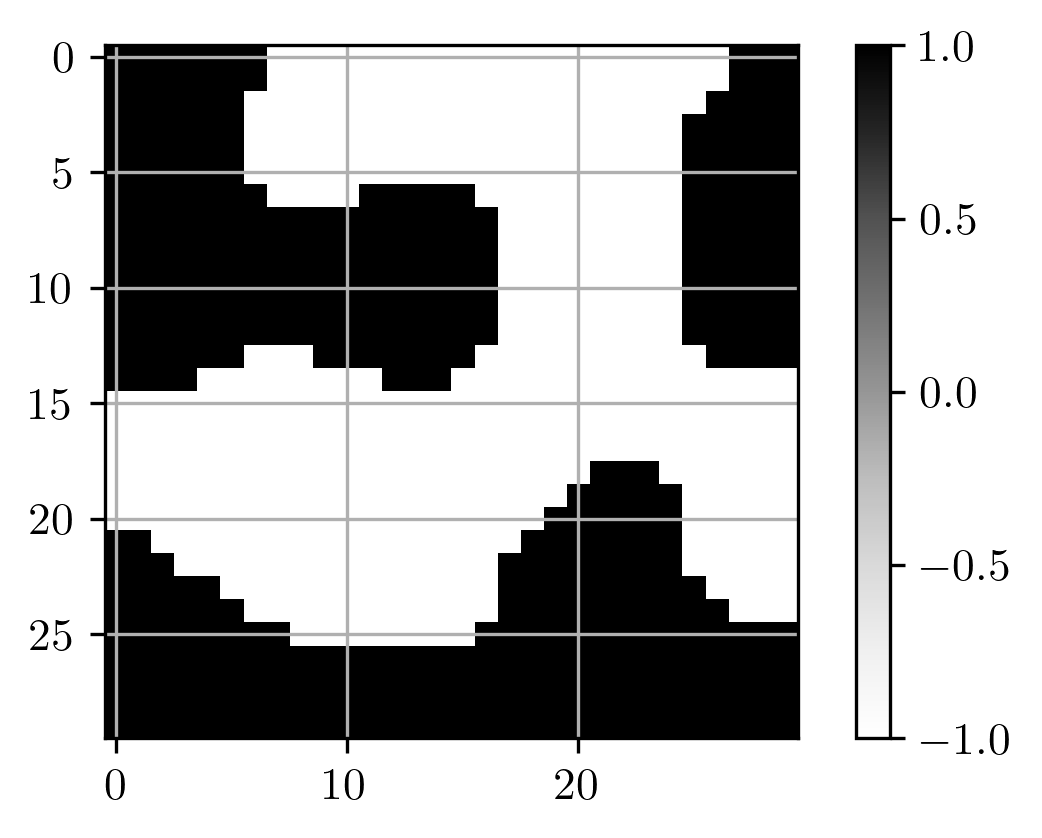

In [ ]:
plt.imshow(mask_target, cmap="Greys", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

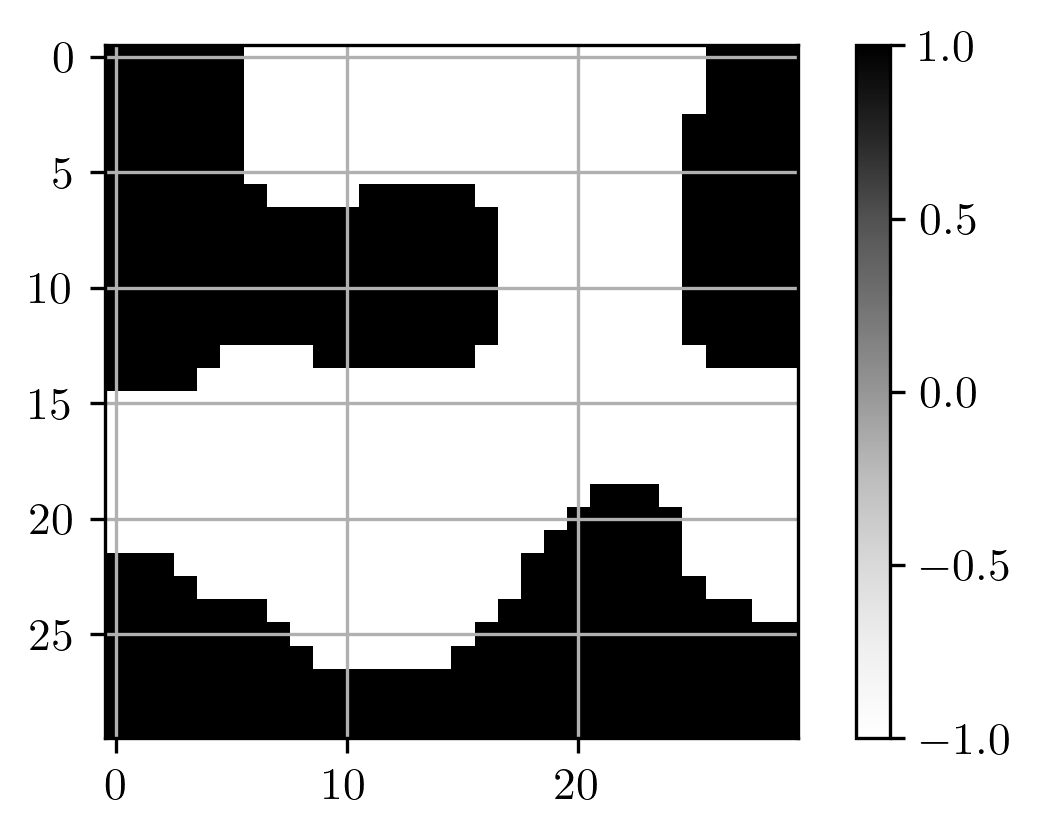

In [ ]:
plt.imshow(forward(latent_input, brush_input), cmap="Greys", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [ ]:
loss_fn(latent_input, brush_input, mask_target)

Array(0.02429082, dtype=float32)